In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,PolynomialFeatures,StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier,StackingClassifier,GradientBoostingClassifier
#from mlxtend.classifier import StackingClassifier
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,plot_confusion_matrix,classification_report
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX,SARIMAXResults
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Cencus project

In [2]:
# importing dataset
df = pd.read_csv('census-income.csv',skipinitialspace=True)
# Changing columns name for ease of of analysis
df.columns = df.columns.str.replace('-','_')
# Renaming salary column as salary
df = df.rename(columns = {"Unnamed: 14":'salary'})
df['salary'] = df['salary'].map({'<=50K':0,'>50K':1})
df.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0


In [3]:
# Checking shape of data
df.shape

(32561, 15)

In [4]:
# Checking information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  salary          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


## 1. EDA

In [5]:
# checking missing value
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

No null values found in numerical columns. Let's explore object colums

In [6]:
# fetching columns having dtype is object
x = [df.dtypes=='object'][0]
# boolean indexing
object_columns = x[x].index
# finding unique value counts of each object columns
df[object_columns].nunique()

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
dtype: int64

### a) Replace all the missing values with NA.

In [7]:
# checking unique values of workclass
df.workclass.unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [8]:
# '?' is replaced by None in workclass
df.loc[df.workclass=='?','workclass']=np.nan
df.workclass.isnull().sum()

1836

In [9]:
# checking unique values of education
df.education.unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [10]:
# checking unique values of marital_status
df.marital_status.unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [11]:
# checking unique values of occupation
df.occupation.unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [12]:
# '?' is replaced by None in occupation
df.loc[df.occupation=='?','occupation']=np.nan
df.occupation.isnull().sum()

1843

In [13]:
# checking unique values of relationship
df.relationship.unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [14]:
# checking unique values of race
df.race.unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [15]:
# checking unique values of sex
df.sex.unique()

array(['Male', 'Female'], dtype=object)

In [16]:
# checking unique values of native_country
df.native_country.unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [17]:
# '?' is replaced by None in native_country
df.loc[df.native_country=='?','native_country']=np.nan
df.native_country.isnull().sum()

583

In [18]:
# checking unique values of salary
df.salary.unique()

array([0, 1], dtype=int64)

In [19]:
# Recheking null values
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
salary               0
dtype: int64

### b) Remove all the rows that contain NA values.

In [20]:
df_with_null = df.copy()
# storing index of null values
null_index = []
# creating loop to store index of null values
for index,values in df.iterrows():
    if values.isna().any():
        null_index.append(index)

# creating a data frame without null values
df.drop(index=list(set(null_index)),inplace=True)
print('% information loss after removing rows conatining null values = ',round((1-df.shape[0]/df_with_null.shape[0])*100,2),'%')

% information loss after removing rows conatining null values =  7.37 %


In [21]:
# Recheking null values
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

## 2. Feature Selection
### 2.a) Plotting distribution of object_columns

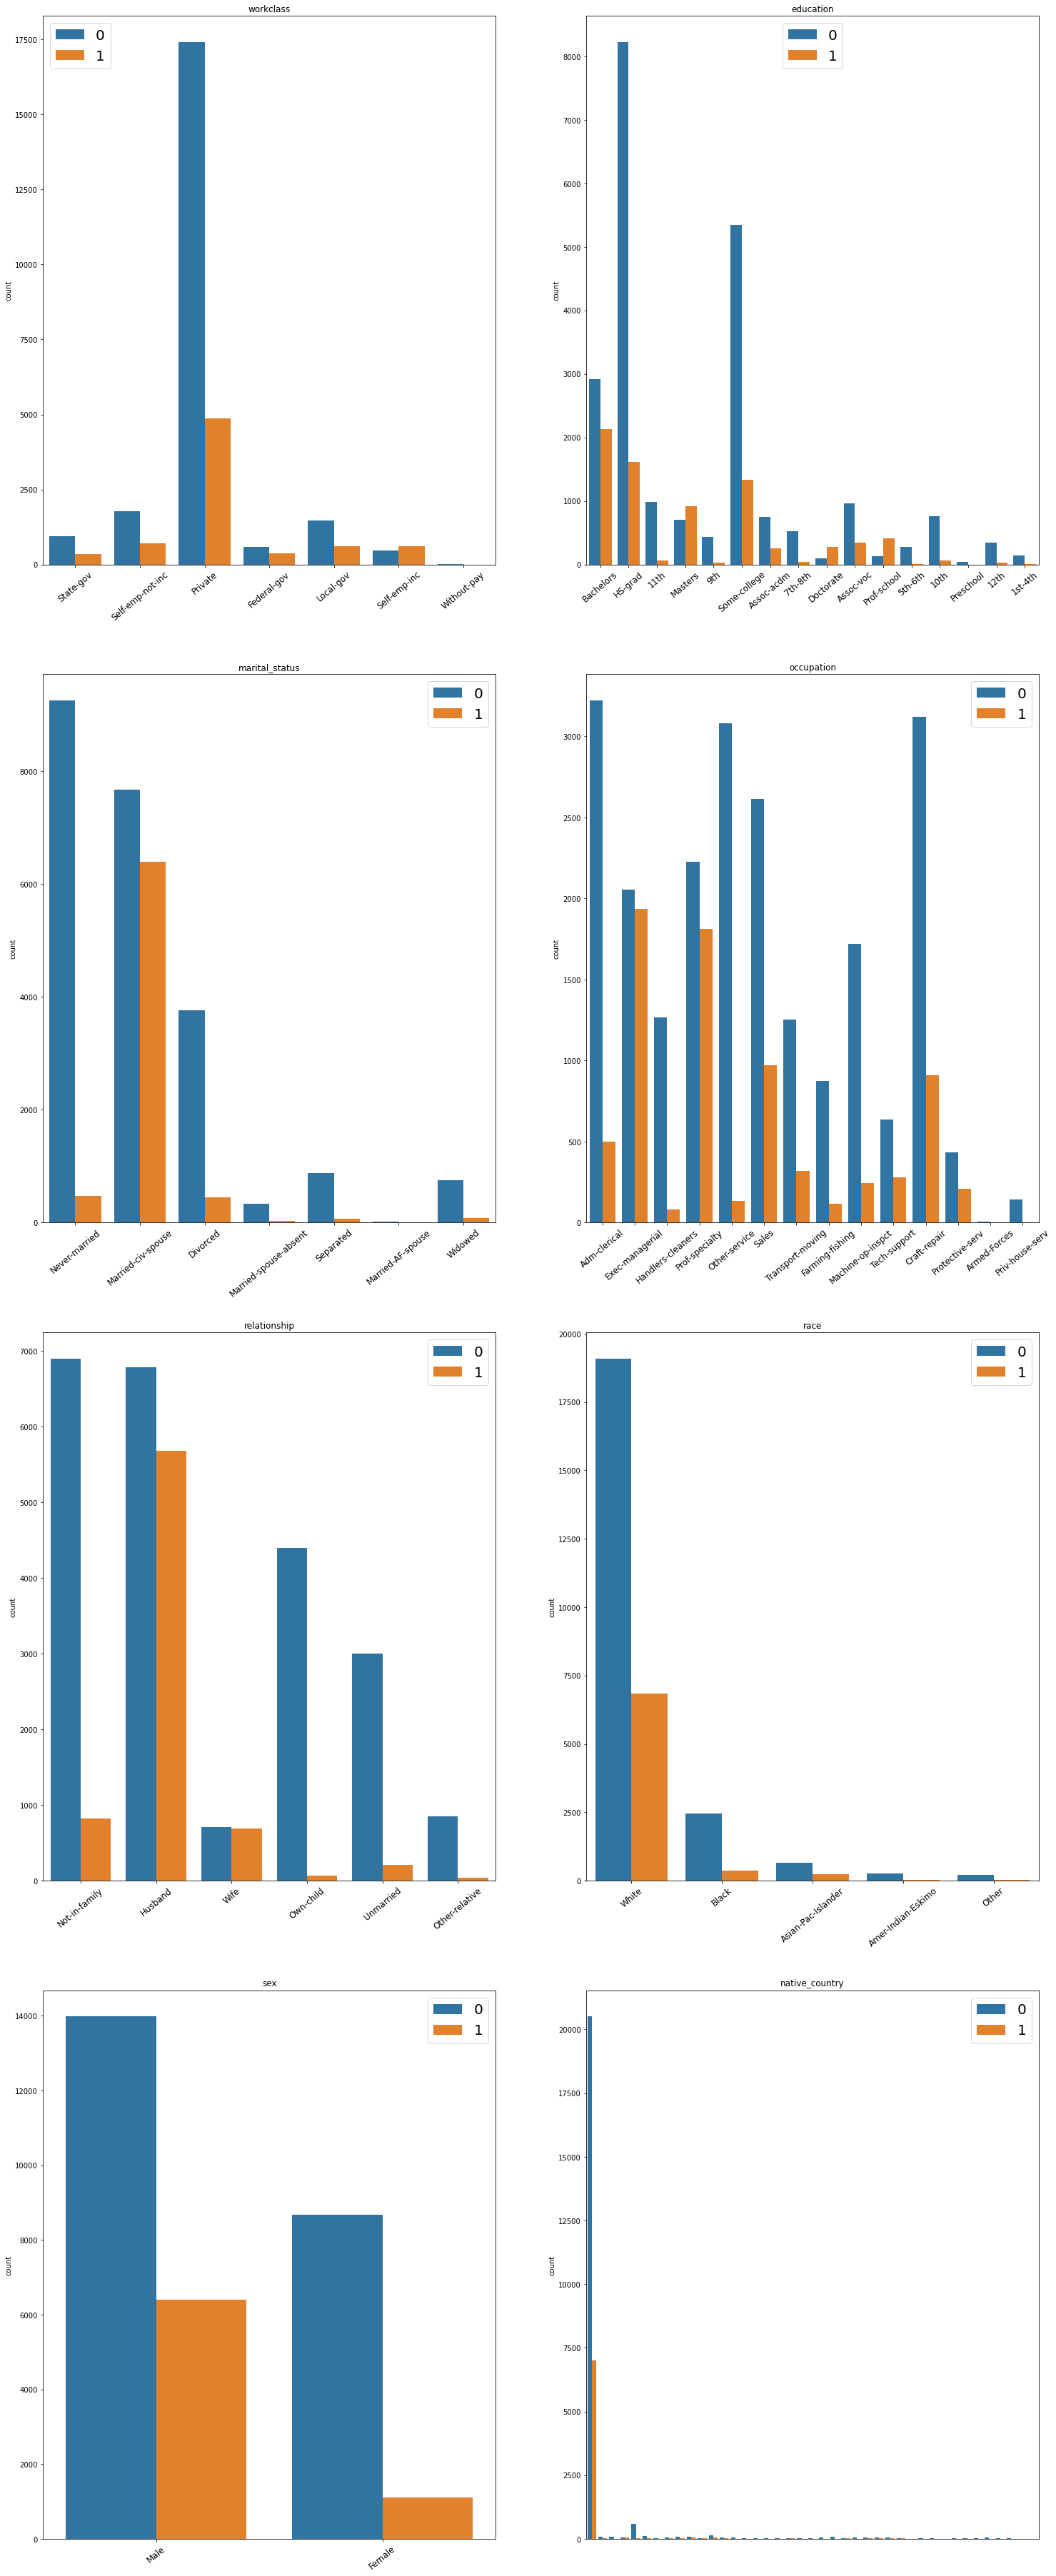

In [22]:
ncols = 2
nrows = (len(object_columns)+1)//2
plt.subplots(nrows,ncols,figsize=(25,65))

for plot_position, plot in enumerate(object_columns):
    plt.subplot(nrows,ncols,plot_position+1)
    sns.countplot(x=plot,hue='salary',data=df)
    if plot=='native_country':
        plt.xticks([])
    else: 
        plt.xticks(rotation=40,fontsize=12)
    plt.xlabel('',fontsize=15)
    plt.title(plot)
    plt.legend(fontsize=20)

#### Observations from plots:
1. In `workclass` column most of the data are **`Private`**
1. In `education` column **`Docotorate`, `Prof-school`, `Masters`** have higher salary ratio compare to others.
1. In `marital_status` column **`Married-civ-spouse`, `Married-AF-spouse`** have higher salary ratio compare to others.
1. In `sex` column **`Female`** has lower income compare to **`male`**
1. In `native_country` majority of data is **`United-States`**
1. In `race` majority of data is **`White`**

#### Counting distribution unique data in `workclass`, `native_country` and `race` colum

In [23]:
# Cheking unique value_counts of workclass
df.workclass.value_counts(normalize=True).head(3)

Private             0.738877
Self-emp-not-inc    0.082853
Local-gov           0.068530
Name: workclass, dtype: float64

Since $74\%$ data is `Private` it will not be a good predictor of Salary.

In [24]:
# Cheking unique value_counts of native_country
df.native_country.value_counts(normalize=True).head(3)

United-States    0.911876
Mexico           0.020224
Philippines      0.006233
Name: native_country, dtype: float64

Since $91\%$ data is `United-States` it will not be a good predictor of Salary.

In [25]:
# Cheking unique value_counts of race
df.race.value_counts(normalize=True).head(3)

White                 0.859790
Black                 0.093396
Asian-Pac-Islander    0.029673
Name: race, dtype: float64

Since $86\%$ data is `White` it will not be a good predictor of Salary.

From above observations It can be concluded that `workclass`,`native_country` and `race` have very low prediction power. I will also conclude this using IV analysis.

### 2.b) IV - Analysis

In [26]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

df_new=pd.DataFrame(columns=['Feature','IV-Score'])
col_list = list(df.columns)
for col in col_list:
    if col == 'salary': 
        continue
    elif df[col].dtype == 'object':
        data, iv = calculate_woe_iv(df, col, 'salary')
        df_new=df_new.append({'Feature':col, 'IV-Score': iv}, ignore_index=True)
df_new.sort_values(by='IV-Score')

,Feature,IV-Score
5,race,0.067008
7,native_country,0.081235
0,workclass,0.121411
6,sex,0.298293
1,education,0.721587
3,occupation,0.770924
2,marital_status,1.315122
4,relationship,1.498814


From IV-analysis it is confirmed that `workclass`,`native_country` and `race` have very low prediction power. So, I can remove those columns.

In [29]:
object_columns = object_columns.drop(['workclass','native_country','race'])

### 2.c) Plotting distribution of numeric_columns

In [30]:
# fetching numeric columns                          
x = [df.dtypes!='object'][0]
# boolean indexing
numeric_columns = x[x].index

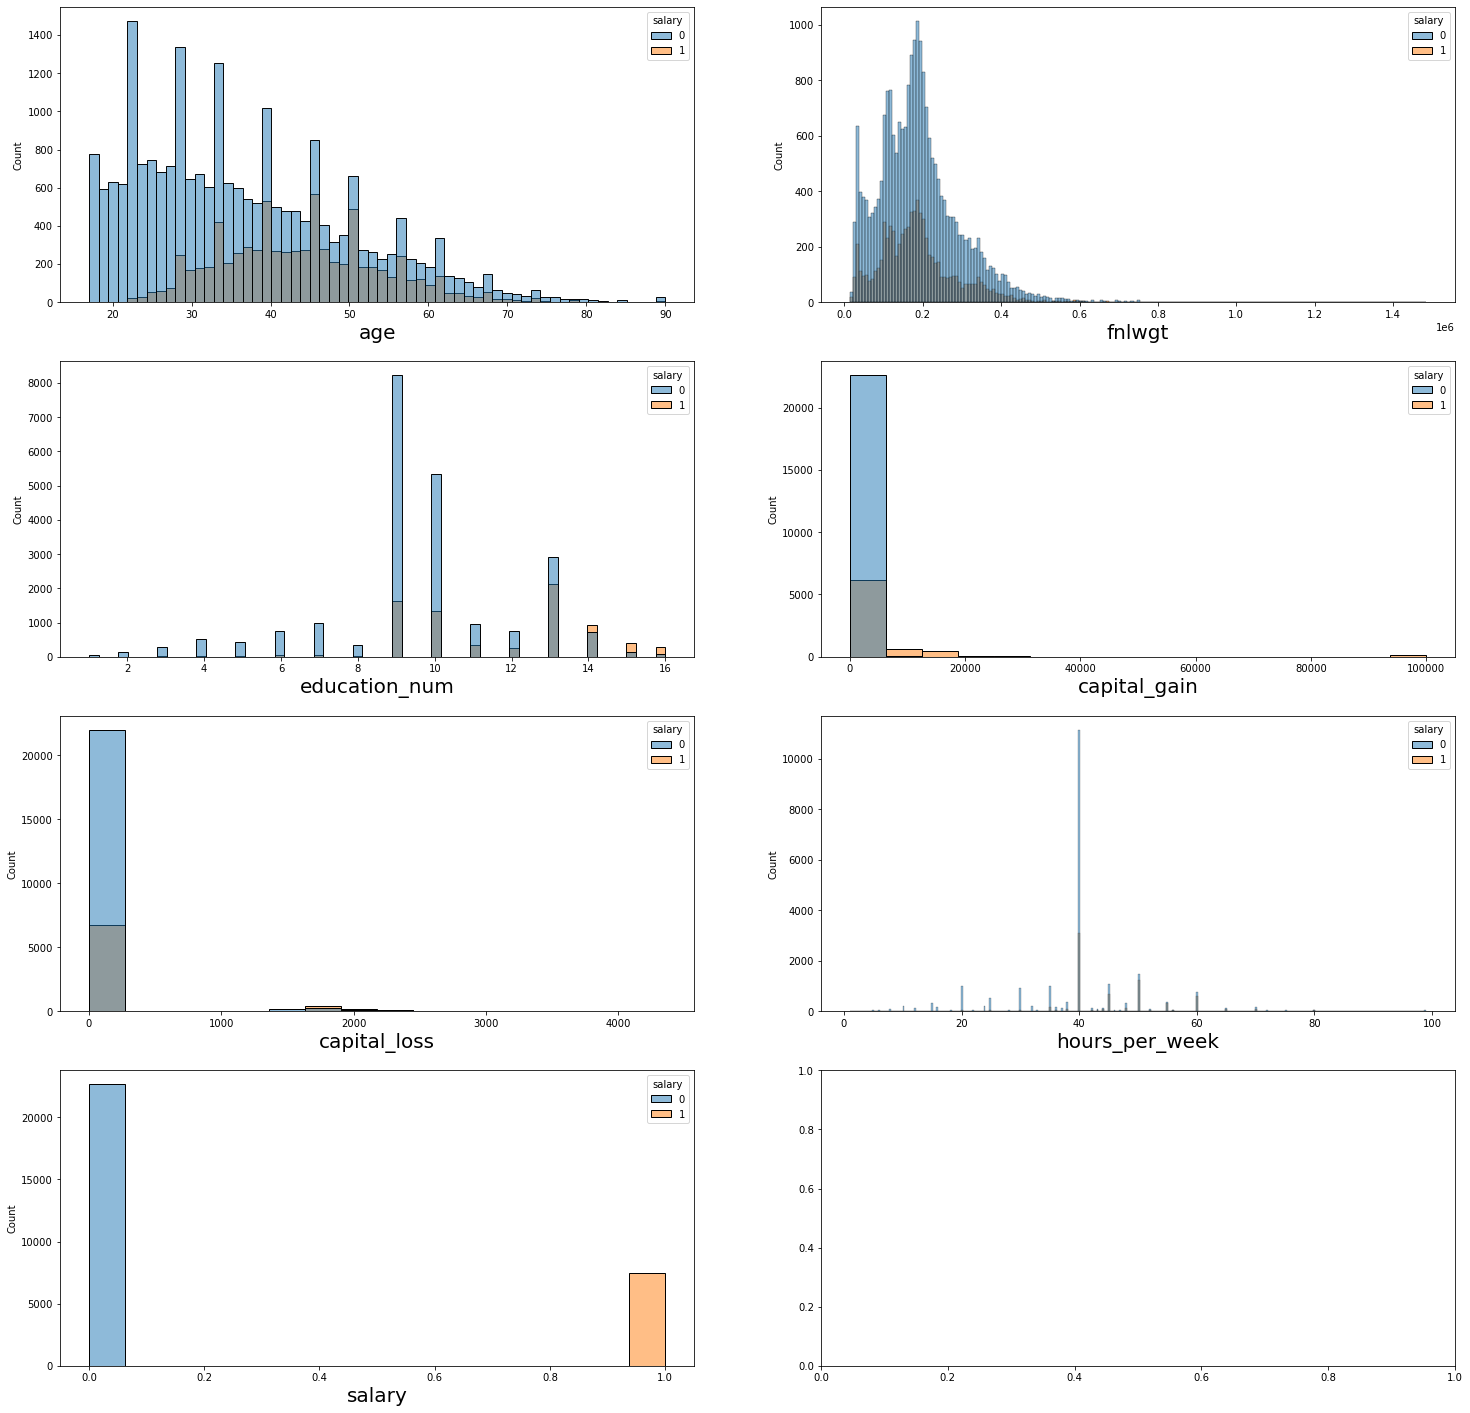

In [31]:
ncols = 2
nrows = (len(numeric_columns)+1)//2
plt.subplots(nrows,ncols,figsize=(25,25))

for plot_position, plot in enumerate(numeric_columns):
    plt.subplot(nrows,ncols,plot_position+1)
    sns.histplot(x=plot,hue='salary',data=df)
    plt.xlabel(plot, fontsize=20)

#### Observations from plots:
1. `Salary` data is imbalanced.
1. Age between 40-50 has earns higher compare to other age group
1. Since most of the values in `capital_gain` and `capital_loss` are $0$.
1. `fnlwgt` has the same type of distrubution for higher salary and lower salary. So it is not a good predictor of salary.

From above observations It can be concluded that `capital_gain` , `capital_loss` and `fnlwgt` have very low prediction power. So, I can remove those columns

In [32]:
numeric_columns = numeric_columns.drop(['capital_gain','capital_loss','fnlwgt','salary'])

### 2.d) Ordinal Encoding of object columns based on higher % of >50K Salary
Let's make a function which will give an ordinal arrangement to all unique values in a particular object column.

In [38]:
#Creating a function to get '%>50K' distribution for a given feature
def Income_ratio(features,data=df):
    Df = pd.crosstab(index = data[features], columns=data.salary, values=data.salary, 
                                aggfunc="count").reset_index()
    Df['%>50K']=100*Df[1]/(Df[0]+Df[1])
    return Df.sort_values(by='%>50K',ascending=False)

### 2.e) Checking Multi-colinearity among features

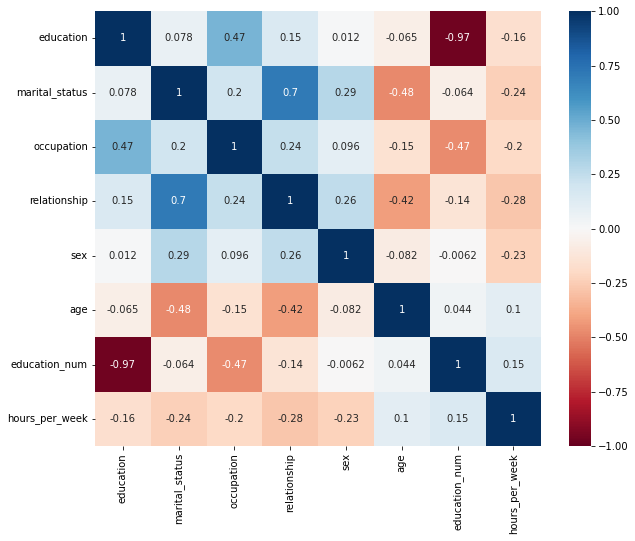

In [39]:
# selecting features
X = df.drop('salary',axis=1)

# Selecting the  features to be encoded
oe = OrdinalEncoder(categories=[
                          Income_ratio('education')['education'].values,
                          Income_ratio('marital_status')['marital_status'].values,     
                          Income_ratio('occupation')['occupation'].values,
                          Income_ratio('relationship')['relationship'].values,
                          Income_ratio('sex')['sex'].values,])

# Ordinal encoding of object columns
X_object = pd.DataFrame(oe.fit_transform(X[object_columns]),columns=X[object_columns].columns)
# merging Object and numeric columns
X = pd.concat([X_object,X[numeric_columns].reset_index(drop=True)],axis=1)

# Plotting correlation among features
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),cmap='RdBu',center=0,vmin=-1,vmax=1,annot=True)
plt.show()

**`education_num`**and **`education`** column shows strong co-linearity. So, I can remove one of this column.

In [40]:
numeric_columns = numeric_columns.drop('education_num')

## 4. Model building - Logistic Regression:
#### Spliting the dataset into train and test
Let's make a model with imbalanced dataset

In [41]:
X = df.drop('salary',axis=1)
y = df.salary

# train-test split for ordinal encoding
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Selecting the  features to be encoded
oe = OrdinalEncoder(categories=[
                          Income_ratio('education')['education'].values,
                          Income_ratio('marital_status')['marital_status'].values,     
                          Income_ratio('occupation')['occupation'].values,
                          Income_ratio('relationship')['relationship'].values,
                          Income_ratio('sex')['sex'].values,])

# encoding
X_train_object = pd.DataFrame(oe.fit_transform(X_train[object_columns]),columns=X_train[object_columns].columns)
X_test_object = pd.DataFrame(oe.transform(X_test[object_columns]),columns=X_test[object_columns].columns)

# merging with numeric(non-encoded) data set
X_train = pd.concat([X_train_object,X_train[numeric_columns].reset_index(drop=True)],axis=1)
X_test = pd.concat([X_test_object,X_test[numeric_columns].reset_index(drop=True)],axis=1)

#### Model building

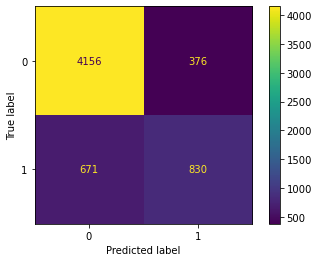

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4532
           1       0.69      0.55      0.61      1501

    accuracy                           0.83      6033
   macro avg       0.77      0.73      0.75      6033
weighted avg       0.82      0.83      0.82      6033



In [42]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(logreg,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

recall for `>50K` is only $55\%$. This is because of imbalanced data. Let's apply class_weight hyperparameter as balanced.

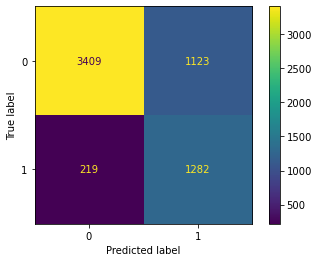

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      4532
           1       0.53      0.85      0.66      1501

    accuracy                           0.78      6033
   macro avg       0.74      0.80      0.75      6033
weighted avg       0.84      0.78      0.79      6033



In [43]:
logreg = LogisticRegression(class_weight='balanced',max_iter=100)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(logreg,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

Now recall value improves from $55\%\to85\%$. Let's apply polynomial features to check result is improved or not.

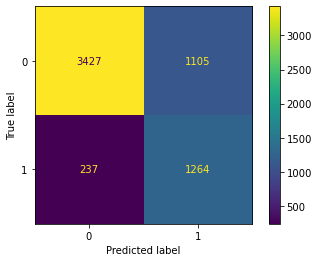

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      4532
           1       0.53      0.84      0.65      1501

    accuracy                           0.78      6033
   macro avg       0.73      0.80      0.74      6033
weighted avg       0.84      0.78      0.79      6033



In [44]:
# Applying polynomial of degree=5
poly = PolynomialFeatures(degree=3,include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# logistic regression
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_poly,y_train)
y_pred = logreg.predict(X_test_poly)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(logreg,X_test_poly,y_test)
plt.show()
print(classification_report(y_test,y_pred))

No to much improvement found.

#### Hyperparameter optimization for logistic regression

In [47]:
# Regularization parameters
penalty = ['l1', 'l2', 'elasticnet']
# Inverse of regularization strength
C = [0.1,0.5,1,5]
# Maximum number of iterations taken for the solvers to converge
max_iter = [100,1000]

random_grid_lr = {'penalty': penalty,
                  'C': C,
                  'max_iter': max_iter}


lr = LogisticRegression(class_weight='balanced')
lr_rscv = RandomizedSearchCV(estimator=lr,param_distributions=random_grid_lr,n_iter=100,cv=3,verbose=0,random_state=0)
lr_rscv.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
                   n_iter=100,
                   param_distributions={'C': [0.1, 0.5, 1, 5],
                                        'max_iter': [100, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=0)

In [48]:
# Checking best parameters
lr_rscv.best_params_

{'penalty': 'l2', 'max_iter': 100, 'C': 1}

In [49]:
lr = LogisticRegression(class_weight='balanced',C=1)
accuracy = round(np.mean(cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=5)),2)
print('accuracy = ',accuracy)

accuracy =  0.78


## 5. KNN

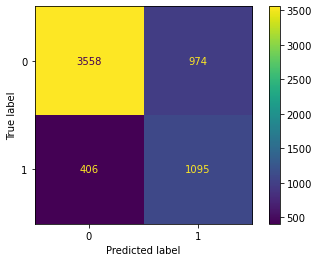

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4532
           1       0.53      0.73      0.61      1501

    accuracy                           0.77      6033
   macro avg       0.71      0.76      0.73      6033
weighted avg       0.81      0.77      0.78      6033



In [50]:
# Random over sampling
ros = RandomOverSampler()
X_train_ros,y_train_ros = ros.fit_resample(X_train,y_train)

# Scaling
sc = StandardScaler()
X_train_scl = sc.fit_transform(X_train_ros)
X_test_scl = sc.transform(X_test)

# Knn model building
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scl,y_train_ros)
y_pred = knn.predict(X_test_scl)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(knn,X_test_scl,y_test)
plt.show()
print(classification_report(y_test,y_pred))

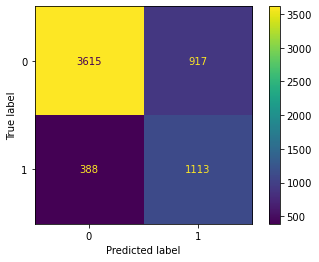

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4532
           1       0.55      0.74      0.63      1501

    accuracy                           0.78      6033
   macro avg       0.73      0.77      0.74      6033
weighted avg       0.81      0.78      0.79      6033



In [51]:
# Knn model building
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scl,y_train_ros)
y_pred = knn.predict(X_test_scl)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(knn,X_test_scl,y_test)
plt.show()
print(classification_report(y_test,y_pred))

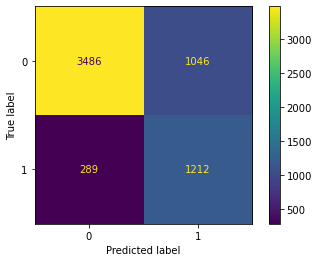

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      4532
           1       0.54      0.81      0.64      1501

    accuracy                           0.78      6033
   macro avg       0.73      0.79      0.74      6033
weighted avg       0.83      0.78      0.79      6033



In [52]:
# Knn model building
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scl,y_train_ros)
y_pred = knn.predict(X_test_scl)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(knn,X_test_scl,y_test)
plt.show()
print(classification_report(y_test,y_pred))

## 6. Random Forest:

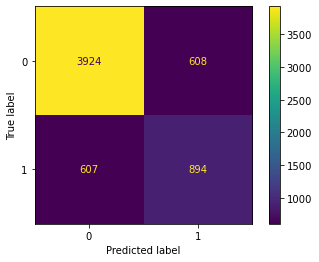

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4532
           1       0.60      0.60      0.60      1501

    accuracy                           0.80      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.80      0.80      0.80      6033



In [84]:
# Build Random forest
rf = RandomForestClassifier(class_weight='balanced',n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(rf,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

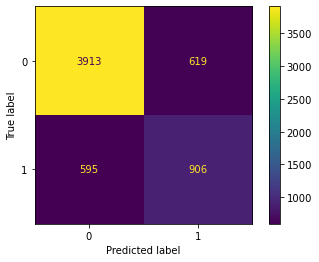

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4532
           1       0.59      0.60      0.60      1501

    accuracy                           0.80      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.80      0.80      0.80      6033



In [54]:
# Build a decision tree model where the dependent variable is “X”(Yearly Income) and the rest of the variables as independent variables.
rf = RandomForestClassifier(class_weight='balanced_subsample')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(rf,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

## 7. Voting Classifier

In [89]:
# Random over sampling
ros = RandomOverSampler()
X_train_ros,y_train_ros = ros.fit_resample(X_train,y_train)

# Defining model
sc = StandardScaler()
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=15)
rf = RandomForestClassifier()
pipeline = make_pipeline(sc,knn)

estimators = [('lr',lr),('rf',rf),('knn',pipeline)]

In [90]:
# Checking accuracy of individual model
for estimator in estimators:
    x = cross_val_score(estimator[1],X_train_ros,y_train_ros,cv=3,scoring='accuracy')
    print(estimator[0],np.round(np.mean(x),2))

lr 0.8
rf 0.89
knn 0.81


In [95]:
# Hard voting
vc = VotingClassifier(estimators,voting='hard')
x = cross_val_score(vc,X_train_ros,y_train_ros,cv=3,scoring='accuracy')
print(np.round(np.mean(x),2))

0.84


In [94]:
# Soft voting
vc = VotingClassifier(estimators,voting='soft')
x = cross_val_score(vc,X_train_ros,y_train_ros,cv=3,scoring='accuracy')
print(np.round(np.mean(x),2))

0.85


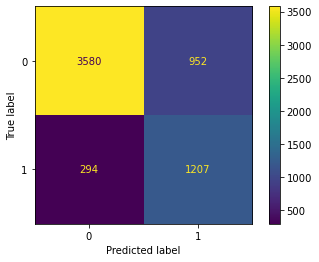

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4532
           1       0.56      0.80      0.66      1501

    accuracy                           0.79      6033
   macro avg       0.74      0.80      0.76      6033
weighted avg       0.83      0.79      0.80      6033



In [100]:
# training model and prediction
vc.fit(X_train_ros,y_train_ros)
y_pred = vc.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(vc,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

In [104]:
for w_lr in range(1,5,2):
    for w_rf in range(1,5,2):
        for w_knn in range(1,5,2):
            vc = VotingClassifier(estimators,voting='soft',weights=[w_lr,w_rf,w_knn])
            x = cross_val_score(vc,X_train_ros,y_train_ros,cv=3,scoring='accuracy')
            print(f'for lr_weight = {w_lr}\trf_weight = {w_rf}\t knn_weight = {w_knn}\t accuracy = ',round(np.mean(x),2))          

for lr_weight = 1	 rf_weight = 1	 knn_weight = 1	 accuracy =  0.85
for lr_weight = 1	 rf_weight = 1	 knn_weight = 3	 accuracy =  0.84
for lr_weight = 1	 rf_weight = 3	 knn_weight = 1	 accuracy =  0.88
for lr_weight = 1	 rf_weight = 3	 knn_weight = 3	 accuracy =  0.86
for lr_weight = 3	 rf_weight = 1	 knn_weight = 1	 accuracy =  0.84
for lr_weight = 3	 rf_weight = 1	 knn_weight = 3	 accuracy =  0.83
for lr_weight = 3	 rf_weight = 3	 knn_weight = 1	 accuracy =  0.86
for lr_weight = 3	 rf_weight = 3	 knn_weight = 3	 accuracy =  0.85


## 8. Support Vector Machine

SVM gives only $0.8\%$ accuracy

## 9. Bagging Classifier 
#### estimator= Logistic regression

In [122]:
bag = BaggingClassifier(base_estimator=LogisticRegression(),
                        n_estimators=20,
                        max_samples=0.5,
                        bootstrap=True,
                        random_state=42,
                        n_jobs=-1,
                        verbose=0,
                        oob_score=True)
#print('OOB Score = ',bag.oob_score_)
x = cross_val_score(bag,X_train_ros,y_train_ros,cv=3,scoring='accuracy')
print('accuracy = ',np.round(np.mean(x),2))

accuracy =  0.8


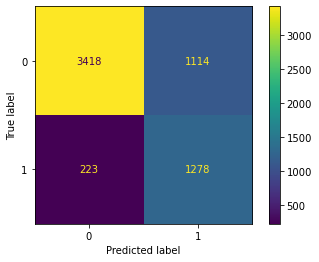

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      4532
           1       0.53      0.85      0.66      1501

    accuracy                           0.78      6033
   macro avg       0.74      0.80      0.75      6033
weighted avg       0.84      0.78      0.79      6033



In [124]:
# training model and prediction
bag.fit(X_train_ros,y_train_ros)
y_pred = bag.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(bag,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

#### estimator= KNeighborsClassifier

In [125]:
pipeline = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=15))

bag = BaggingClassifier(base_estimator=pipeline,
                        n_estimators=20,
                        max_samples=0.5,
                        bootstrap=True,
                        random_state=42,
                        n_jobs=-1,
                        verbose=0)

x = cross_val_score(bag,X_train_ros,y_train_ros,cv=3,scoring='accuracy')
print(np.round(np.mean(x),2))

0.81


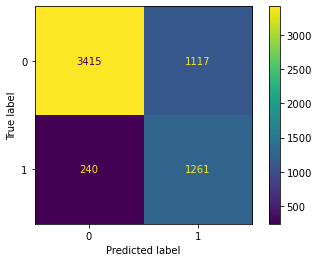

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4532
           1       0.53      0.84      0.65      1501

    accuracy                           0.78      6033
   macro avg       0.73      0.80      0.74      6033
weighted avg       0.83      0.78      0.79      6033



In [126]:
# training model and prediction
bag.fit(X_train_ros,y_train_ros)
y_pred = bag.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(bag,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

## 10. Stacking

In [141]:
pipe = make_pipeline(StandardScaler(),KNeighborsClassifier())
estimators = [('rf',RandomForestClassifier()),
              ('lr',LogisticRegression()),
              ('gb',GradientBoostingClassifier(),
               'pipe',pipe)]

stack = StackingClassifier(estimators=estimators,
                           final_estimator=RandomForestClassifier(),
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

# training model and prediction
stack.fit(X_train_ros,y_train_ros)

StackingClassifier(cv=3,
                   estimators=[('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression()),
                               ('gb', GradientBoostingClassifier(), 'pipe',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier(), n_jobs=-1,
                   verbose=1)

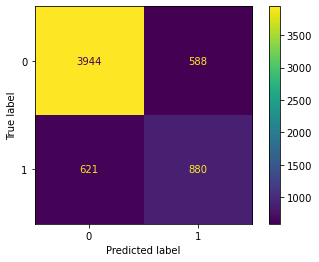

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4532
           1       0.60      0.59      0.59      1501

    accuracy                           0.80      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.80      0.80      0.80      6033



In [142]:
y_pred = stack.predict(X_test)

# Build a confusion matrix and find the accuracy
plot_confusion_matrix(stack,X_test,y_test)
plt.show()
print(classification_report(y_test,y_pred))

# Population project

In [143]:
population = pd.read_csv('popdata _3_ _2_.csv',parse_dates=['date'],index_col='date')
# checking 1st data of time series
population.head(3)

,value
date,
1952-01-01,127299.0
1952-02-01,127517.0
1952-03-01,127721.0


In [144]:
# checking last data of time series
population.tail(3)

,value
date,
2019-10-01,300972.035
2019-11-01,301144.949
2019-12-01,301299.946


In [145]:
# Checking datatypes and null value
population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


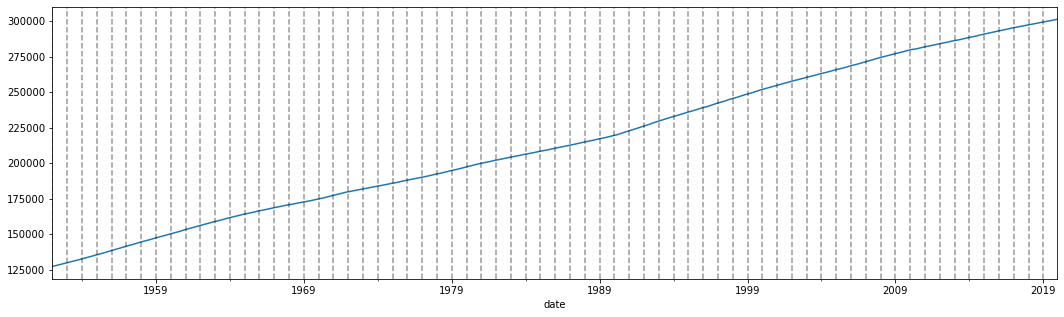

In [146]:
# plotting popilation data
population.plot(figsize=(18,5),legend=False)
for year in range (1952,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

There is a clear posetive trend. Let's check trend of population growth.

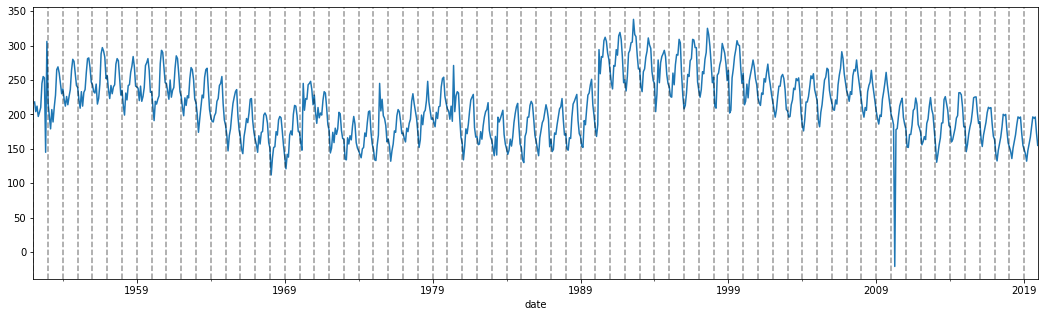

In [147]:
# plotting population growth with time
population['pop_growth'] = population.value - population.value.shift(1)
population['pop_growth'].plot(figsize=(18,5),legend=False)
for year in range (1952,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

No posetive or negative trend observed. Seasonality is observed. Let's have a close look of seasonal data taking small samples (8 years data -1964-1972)

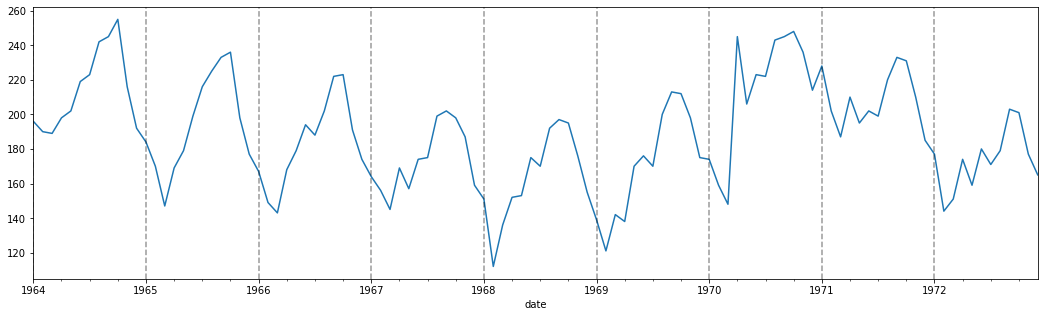

In [148]:
start_date = pd.to_datetime('1964-01-01')
end_date = pd.to_datetime('1972-12-01')
population.loc[start_date:end_date,'pop_growth'].plot(figsize=(18,5),legend=False)
for year in range (1964,1973):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

Strong seasonality observed. Let's remove the seasonality and plot again.

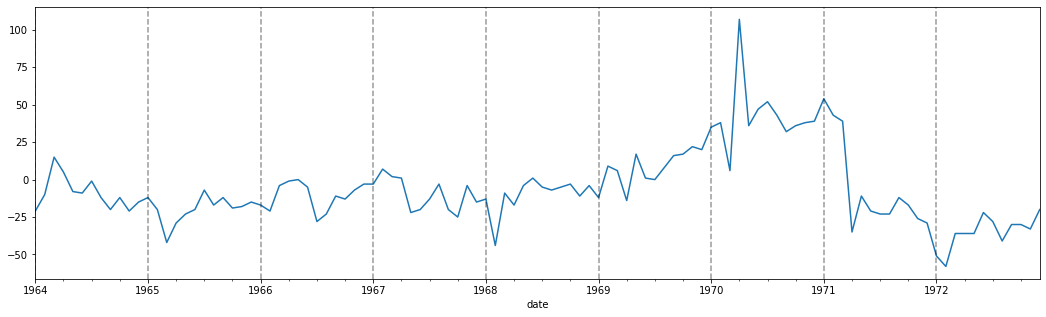

In [149]:
population['growth shift-12'] = population['pop_growth'] - population['pop_growth'].shift(12)
population.loc[start_date:end_date:,'growth shift-12'].plot(figsize=(18,5),legend=False)
for year in range (1964,1973):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

Now data looks stationary. Let's check Dickey-Fuller test.

In [150]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f'%result[0])
    print('p-value: %f'%result[1])
    
perform_adf_test(population['growth shift-12'].dropna())

ADF Statistic: -5.561085
p-value: 0.000002


Since, p-value is <0.05 I can reject null hypothesis $(\phi=1)$ and the data is stationary now. 

Let's plot ACF and PACF.

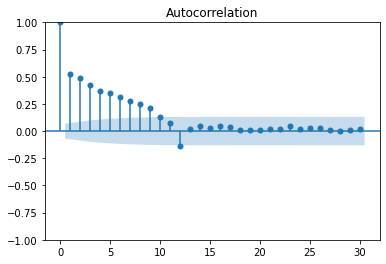

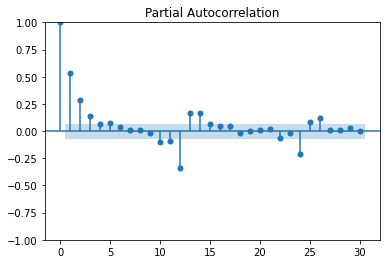

In [151]:
plot_acf(population['growth shift-12'].dropna());
plot_pacf(population['growth shift-12'].dropna());

In [152]:
# Let's check which model is best
order = auto_arima(population['growth shift-12'].dropna(), trace=True)
order.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7299.294, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7037.709, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7142.541, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7298.385, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6971.903, Time=0.64 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6958.354, Time=0.66 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6957.425, Time=1.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6955.380, Time=1.32 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=6956.454, Time=1.48 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6955.998, Time=1.66 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=6953.525, Time=0.58 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=6955.588, Time=0.56 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=6954.590, Time=1.51 sec
 ARIMA(4,0,1)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  803
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -3470.762
Date:                Fri, 23 Dec 2022   AIC                           6953.525
Time:                        05:19:50   BIC                           6981.655
Sample:                    02-01-1953   HQIC                          6964.329
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3263      0.016     20.017      0.000       0.294       0.358
ar.L2          0.2097      0.035      5.983      0.000       0.141       0.278
ar.L3          0.1025      0.046      2.207      0.027       0.011       0.194
ar.L4          0.0370      0.052      0.705      0.481      -0.066       0.140
ar.L5          0.0709      0.057      1.238      0.216      -0.041       0.183
sigma2       332.2365      3.540     93.845      0.000     325.298     339.175
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             96682.41
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on above result `growth shift-12` is best fit for ARIMA(5,0,0)(0,0,0)[0]

$\therefore$ For `pop_growth` best model will be SARIMA(5,0,0)(0,1,12)[0]

$\therefore$ For `value` best model will be SARIMA(5,1,0)(0,1,12)[0]

In [153]:
# train-test split
train_end_date = pd.to_datetime('2018-01-01')
test_start_date = train_end_date + timedelta(days=1)

train_data = population[:train_end_date].copy()
test_data = population[test_start_date:].copy()

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

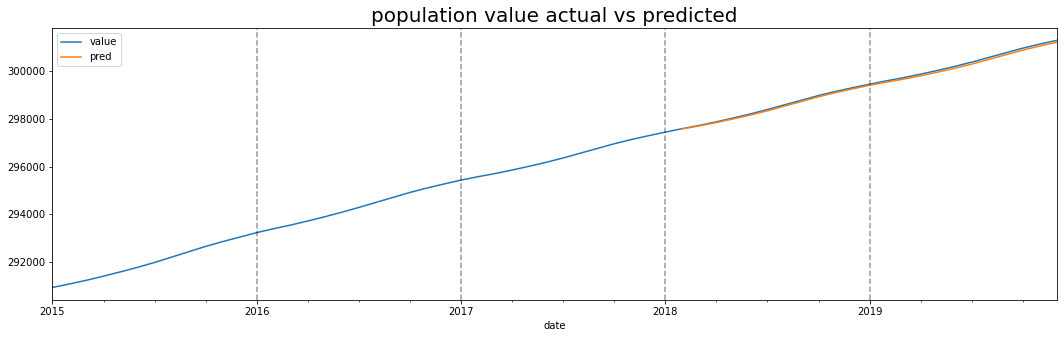

In [154]:
model=SARIMAX(train_data ['value'],order=(5,1,0),seasonal_order=(0,1,0,12))
model_fit=model.fit()
population['pred'] = model_fit.predict(start=pred_start_date, end=pred_end_date)

population.loc[pd.to_datetime('2015-01-01'):,['value','pred']].plot(figsize=(18,5),legend=True)
plt.title('population value actual vs predicted',fontsize=20)
for year in range (1952,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

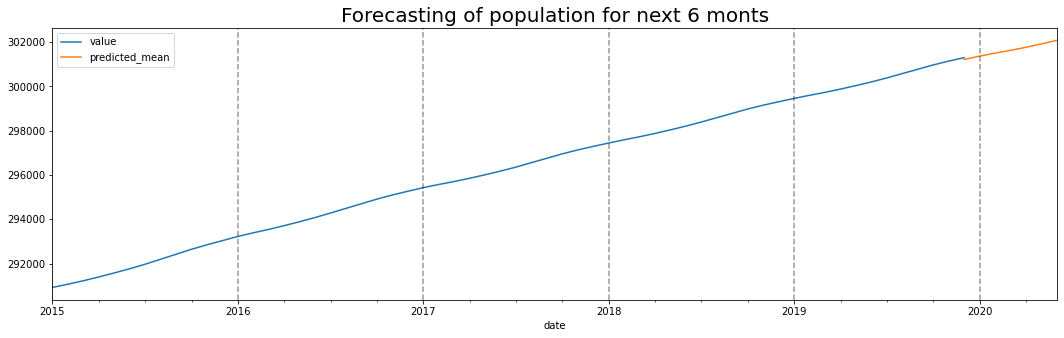

In [155]:
population.loc[pd.to_datetime('2015-01-01'):,['value']].plot(figsize=(18,5),legend=True)
model_fit.predict(start=pred_end_date, end=pred_end_date+timedelta(days=180)).plot(figsize=(18,5),legend=True)
plt.title('Forecasting of population for next 6 monts',fontsize=20)
for year in range (1952,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

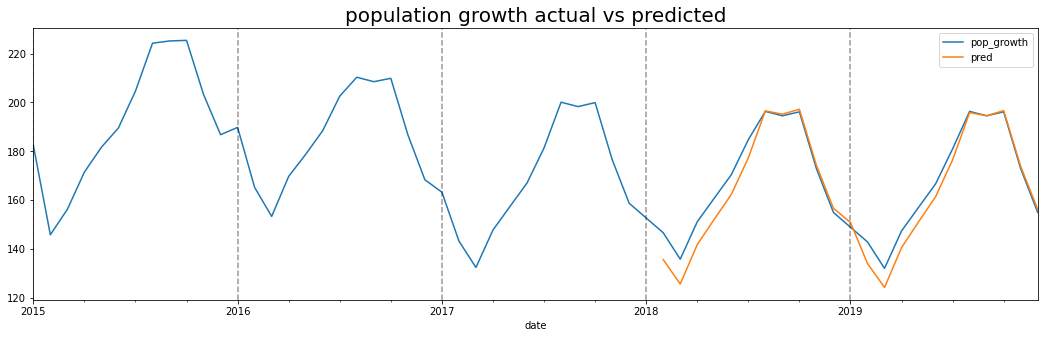

In [156]:
model=SARIMAX(train_data['pop_growth'],order=(5,0,0),seasonal_order=(0,1,0,12))
model_fit=model.fit()
population['pred'] = model_fit.predict(start=pred_start_date, end=pred_end_date+timedelta(days=180))

population.loc[pd.to_datetime('2015-01-01'):,['pop_growth','pred']].plot(figsize=(18,5),legend=True)
plt.title('population growth actual vs predicted',fontsize=20)
for year in range (1952,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)

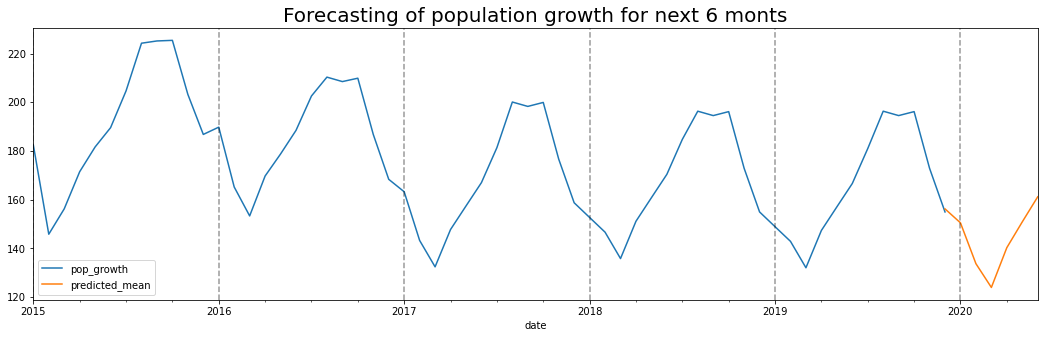

In [157]:
population.loc[pd.to_datetime('2015-01-01'):,['pop_growth']].plot(figsize=(18,5),legend=True)
model_fit.predict(start=pred_end_date, end=pred_end_date+timedelta(days=180)).plot(figsize=(18,5),legend=True)
plt.title('Forecasting of population growth for next 6 monts',fontsize=20)
for year in range (1952,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.4)